In [1]:
#import packages
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
#from intake import open_catalog
import cartopy.io.shapereader as shpreader
#import mygrads as mg
import matplotlib as mpl
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.feature import NaturalEarthFeature
from cartopy.feature import COASTLINE
import math
from sklearn.neighbors import NearestNeighbors

In [2]:
#regridding
import xesmf as xe

In [3]:
f='/project/xprecip/merra2_ncfiles/slp/slp_sixhourly.nc'
DS_slp_6hr=xr.open_dataset(f)
DS_slp_6hr

<xarray.Dataset>
Dimensions:  (lat: 66, lon: 120, time: 61600)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 ... 2022-02-28T18:00:00
  * lon      (lon) float64 -127.5 -126.9 -126.2 -125.6 ... -54.38 -53.75 -53.12
  * lat      (lat) float64 21.0 21.5 22.0 22.5 23.0 ... 51.5 52.0 52.5 53.0 53.5
Data variables:
    SLP      (time, lat, lon) float32 ...

In [4]:
lats=DS_slp_6hr['lat']
lons=DS_slp_6hr['lon']
print(lats)
print(lons)

<xarray.DataArray 'lat' (lat: 66)>
array([21. , 21.5, 22. , 22.5, 23. , 23.5, 24. , 24.5, 25. , 25.5, 26. , 26.5,
       27. , 27.5, 28. , 28.5, 29. , 29.5, 30. , 30.5, 31. , 31.5, 32. , 32.5,
       33. , 33.5, 34. , 34.5, 35. , 35.5, 36. , 36.5, 37. , 37.5, 38. , 38.5,
       39. , 39.5, 40. , 40.5, 41. , 41.5, 42. , 42.5, 43. , 43.5, 44. , 44.5,
       45. , 45.5, 46. , 46.5, 47. , 47.5, 48. , 48.5, 49. , 49.5, 50. , 50.5,
       51. , 51.5, 52. , 52.5, 53. , 53.5])
Coordinates:
  * lat      (lat) float64 21.0 21.5 22.0 22.5 23.0 ... 51.5 52.0 52.5 53.0 53.5
Attributes:
    standard_name:  latitude
    long_name:      latitude
    units:          degrees_north
    axis:           Y
<xarray.DataArray 'lon' (lon: 120)>
array([-127.5  , -126.875, -126.25 , -125.625, -125.   , -124.375, -123.75 ,
       -123.125, -122.5  , -121.875, -121.25 , -120.625, -120.   , -119.375,
       -118.75 , -118.125, -117.5  , -116.875, -116.25 , -115.625, -115.   ,
       -114.375, -113.75 , -113.125, -1

In [5]:
slp_6hr=DS_slp_6hr['SLP']*10e-3 #converts to hectopascals
slp_6hr

<xarray.DataArray 'SLP' (time: 61600, lat: 66, lon: 120)>
array([[[1018.0071 , 1018.0396 , 1018.07874, ..., 1017.5296 ,
         1017.5329 , 1017.5704 ],
        [1018.3212 , 1018.36206, 1018.40375, ..., 1017.8329 ,
         1017.7962 , 1017.8221 ],
        [1018.6371 , 1018.67706, 1018.7271 , ..., 1018.0396 ,
         1018.0687 , 1018.06537],
        ...,
        [1004.41754, 1004.5886 , 1004.4153 , ...,  981.00037,
          980.04285,  979.5071 ],
        [1004.59216, 1004.8458 , 1005.1027 , ...,  981.0954 ,
          980.3854 ,  979.98535],
        [1005.0246 , 1005.37585, 1005.82684, ...,  981.4029 ,
          980.97125,  980.6046 ]],

       [[1018.92114, 1018.86444, 1018.8128 , ..., 1016.0812 ,
         1016.11115, 1016.0869 ],
        [1019.1828 , 1019.14276, 1019.08276, ..., 1016.30115,
         1016.32367, 1016.31946],
        [1019.46277, 1019.4119 , 1019.3578 , ..., 1016.4661 ,
         1016.50366, 1016.54193],
        ...,
        [1008.8563 , 1009.0275 , 1009.2582 , ..., 

In [6]:
slp_time=DS_slp_6hr.time.values
slp_time

array(['1980-01-01T00:00:00.000000000', '1980-01-01T06:00:00.000000000',
       '1980-01-01T12:00:00.000000000', ...,
       '2022-02-28T06:00:00.000000000', '2022-02-28T12:00:00.000000000',
       '2022-02-28T18:00:00.000000000'], dtype='datetime64[ns]')

In [7]:
slp_sorted=slp_6hr.sortby('time')
slp_sorted

<xarray.DataArray 'SLP' (time: 61600, lat: 66, lon: 120)>
array([[[1018.0071 , 1018.0396 , 1018.07874, ..., 1017.5296 ,
         1017.5329 , 1017.5704 ],
        [1018.3212 , 1018.36206, 1018.40375, ..., 1017.8329 ,
         1017.7962 , 1017.8221 ],
        [1018.6371 , 1018.67706, 1018.7271 , ..., 1018.0396 ,
         1018.0687 , 1018.06537],
        ...,
        [1004.41754, 1004.5886 , 1004.4153 , ...,  981.00037,
          980.04285,  979.5071 ],
        [1004.59216, 1004.8458 , 1005.1027 , ...,  981.0954 ,
          980.3854 ,  979.98535],
        [1005.0246 , 1005.37585, 1005.82684, ...,  981.4029 ,
          980.97125,  980.6046 ]],

       [[1018.92114, 1018.86444, 1018.8128 , ..., 1016.0812 ,
         1016.11115, 1016.0869 ],
        [1019.1828 , 1019.14276, 1019.08276, ..., 1016.30115,
         1016.32367, 1016.31946],
        [1019.46277, 1019.4119 , 1019.3578 , ..., 1016.4661 ,
         1016.50366, 1016.54193],
        ...,
        [1008.8563 , 1009.0275 , 1009.2582 , ..., 

In [8]:
print(np.nanmin(slp_sorted[:,:,:],axis=0)) #not what we want

[[1006.4187  1005.7799  1006.04724 ... 1000.30023 1000.4874  1000.2284 ]
 [1005.8429  1005.38403 1005.0054  ...  999.3569   999.35114  999.0313 ]
 [1005.3383  1005.7528  1005.23785 ...  998.4303   998.1994   997.8909 ]
 ...
 [ 953.1554   953.2754   952.7121  ...  938.7847   936.1181   934.4981 ]
 [ 952.9021   953.53375  954.6521  ...  940.10474  937.93475  936.1881 ]
 [ 954.0254   955.1404   955.28906 ...  942.2615   940.6281   938.29034]]


In [8]:
slp_nonans=slp_sorted.dropna(dim='time') #obtains only winter data
slp_nonans

<xarray.DataArray 'SLP' (time: 15400, lat: 66, lon: 120)>
array([[[1018.0071 , 1018.0396 , 1018.07874, ..., 1017.5296 ,
         1017.5329 , 1017.5704 ],
        [1018.3212 , 1018.36206, 1018.40375, ..., 1017.8329 ,
         1017.7962 , 1017.8221 ],
        [1018.6371 , 1018.67706, 1018.7271 , ..., 1018.0396 ,
         1018.0687 , 1018.06537],
        ...,
        [1004.41754, 1004.5886 , 1004.4153 , ...,  981.00037,
          980.04285,  979.5071 ],
        [1004.59216, 1004.8458 , 1005.1027 , ...,  981.0954 ,
          980.3854 ,  979.98535],
        [1005.0246 , 1005.37585, 1005.82684, ...,  981.4029 ,
          980.97125,  980.6046 ]],

       [[1018.92114, 1018.86444, 1018.8128 , ..., 1016.0812 ,
         1016.11115, 1016.0869 ],
        [1019.1828 , 1019.14276, 1019.08276, ..., 1016.30115,
         1016.32367, 1016.31946],
        [1019.46277, 1019.4119 , 1019.3578 , ..., 1016.4661 ,
         1016.50366, 1016.54193],
        ...,
        [1008.8563 , 1009.0275 , 1009.2582 , ..., 

In [9]:
#alternative
slp=[]
args=[]
for i in range(0,len(slp_nonans['time'])):
    each_point=slp_nonans[i,:,:]
    #for k in range(len(lats)):
        #for j in range(len(lons)):
            #each_point=np.nanmin(slp_nonans.values[i,:,:])
    #lat_new=lats.where(each_point==np.nanmin(each_point))
    #lon_new=lons.where(each_point==np.nanmin(each_point))
    #print(lat_new)
    #print(lon_new)
    slp_min_loc=each_point.where(each_point==np.nanmin(each_point))
    slp.append(slp_min_loc)
    #print(np.nanmin(each_point))
    #slp.append(np.nanmin(each_point))
    #args.append(np.argmin(each_point))
            #print(each_point)
            #slp_min=np.nanmin(each_point)
            #print(slp_min)

In [ ]:
#print(args)
print(np.shape(args))

In [23]:
#print(np.shape(slp))

In [10]:
slp_times=xr.concat(slp,dim='time')
print(slp_times)

<xarray.DataArray 'SLP' (time: 15400, lat: 66, lon: 120)>
array([[[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [     

In [37]:
slp_2d=np.min(slp_times,axis=0)
print(slp_2d)

<xarray.DataArray 'SLP' (lat: 66, lon: 120)>
array([[       nan,        nan,        nan, ..., 1012.9105 ,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
        1012.65466],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [ 984.9396 ,        nan,  952.7121 , ...,  959.6021 ,  966.8996 ,
         934.4981 ],
       [ 967.53467,  981.2035 ,        nan, ...,  954.7258 ,  954.8044 ,
         937.72375],
       [ 970.1221 ,  977.3896 ,  980.4278 , ...,  949.96375,  951.42395,
         951.8724 ]], dtype=float32)
Coordinates:
  * lon      (lon) float64 -127.5 -126.9 -126.2 -125.6 ... -54.38 -53.75 -53.12
  * lat      (lat) float64 21.0 21.5 22.0 22.5 23.0 ... 51.5 52.0 52.5 53.0 53.5


In [27]:
print(np.shape(slp_2d))

(66, 120)


In [42]:
slp_new =slp_2d.fillna(0)
slp_new

<xarray.DataArray 'SLP' (lat: 66, lon: 120)>
array([[   0.     ,    0.     ,    0.     , ..., 1012.9105 ,    0.     ,
           0.     ],
       [   0.     ,    0.     ,    0.     , ...,    0.     ,    0.     ,
        1012.65466],
       [   0.     ,    0.     ,    0.     , ...,    0.     ,    0.     ,
           0.     ],
       ...,
       [ 984.9396 ,    0.     ,  952.7121 , ...,  959.6021 ,  966.8996 ,
         934.4981 ],
       [ 967.53467,  981.2035 ,    0.     , ...,  954.7258 ,  954.8044 ,
         937.72375],
       [ 970.1221 ,  977.3896 ,  980.4278 , ...,  949.96375,  951.42395,
         951.8724 ]], dtype=float32)
Coordinates:
  * lon      (lon) float64 -127.5 -126.9 -126.2 -125.6 ... -54.38 -53.75 -53.12
  * lat      (lat) float64 21.0 21.5 22.0 22.5 23.0 ... 51.5 52.0 52.5 53.0 53.5

In [35]:
print(np.shape(slp_new.reshape(-1,1)))

(2897, 1)


In [17]:
print(np.shape(slp_times))

(15400, 66, 120)


In [22]:
min_reduced=slp_times.min(dim=('lat','lon'))
min_reduced

<xarray.DataArray 'SLP' (time: 15400)>
array([979.2721 , 982.6203 , 982.78217, ..., 992.7506 , 992.1627 ,
       991.4049 ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 ... 2022-02-28T18:00:00

In [22]:
min_slp=[]
index=[]
frames=[]
for i in range(0,len(slp_nonans['time'])):
    each_time=slp_nonans[i,:,:] #each frame?
    frames.append(each_time)
#print(np.shape(frames))
for j in range(0,len(frames)):
    #print(j)
    slp_6hr_min=np.nanmin(frames[j]) #indexes each 6 hours, finds a minimum over the lat lon domain
    #print(slp_6hr_min)
    #print(np.shape(slp_6hr_min))
    idx=np.argmin(frames[j])
    min_slp.append(slp_6hr_min)
    index.append(idx)

In [23]:
print(np.shape(min_slp))

(15400,)


In [24]:
times_winter=slp_nonans['time']

In [26]:
slp_mins=xr.DataArray(min_slp,coords={'time':times_winter},dims={'time':times_winter})
slp_mins

<xarray.DataArray (time: 15400)>
array([979.2721 , 982.6203 , 982.78217, ..., 992.7506 , 992.1627 ,
       991.4049 ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 ... 2022-02-28T18:00:00

In [33]:
print(np.shape(np.unique(slp_mins)))

(15046,)


In [29]:
#print(list(index)) #repeating indices count as a single feature?

In [31]:
unique_idx=np.unique(index)
print(np.shape(unique_idx)) #lots of repeating values in original index list

(2897,)


In [47]:
time_mins=slp_sorted.min(dim='time')
time_mins

<xarray.DataArray 'SLP' (lat: 66, lon: 120)>
array([[1006.4187 , 1005.7799 , 1006.04724, ..., 1000.30023, 1000.4874 ,
        1000.2284 ],
       [1005.8429 , 1005.38403, 1005.0054 , ...,  999.3569 ,  999.35114,
         999.0313 ],
       [1005.3383 , 1005.7528 , 1005.23785, ...,  998.4303 ,  998.1994 ,
         997.8909 ],
       ...,
       [ 953.1554 ,  953.2754 ,  952.7121 , ...,  938.7847 ,  936.1181 ,
         934.4981 ],
       [ 952.9021 ,  953.53375,  954.6521 , ...,  940.10474,  937.93475,
         936.1881 ],
       [ 954.0254 ,  955.1404 ,  955.28906, ...,  942.2615 ,  940.6281 ,
         938.29034]], dtype=float32)
Coordinates:
  * lon      (lon) float64 -127.5 -126.9 -126.2 -125.6 ... -54.38 -53.75 -53.12
  * lat      (lat) float64 21.0 21.5 22.0 22.5 23.0 ... 51.5 52.0 52.5 53.0 53.5

In [22]:
lats.where(lats==time_mins['lat'])

<xarray.DataArray 'lat' (lat: 66)>
array([21. , 21.5, 22. , 22.5, 23. , 23.5, 24. , 24.5, 25. , 25.5, 26. ,
       26.5, 27. , 27.5, 28. , 28.5, 29. , 29.5, 30. , 30.5, 31. , 31.5,
       32. , 32.5, 33. , 33.5, 34. , 34.5, 35. , 35.5, 36. , 36.5, 37. ,
       37.5, 38. , 38.5, 39. , 39.5, 40. , 40.5, 41. , 41.5, 42. , 42.5,
       43. , 43.5, 44. , 44.5, 45. , 45.5, 46. , 46.5, 47. , 47.5, 48. ,
       48.5, 49. , 49.5, 50. , 50.5, 51. , 51.5, 52. , 52.5, 53. , 53.5])
Coordinates:
  * lat      (lat) float64 21.0 21.5 22.0 22.5 23.0 ... 51.5 52.0 52.5 53.0 53.5
Attributes:
    standard_name:  latitude
    long_name:      latitude
    units:          degrees_north
    axis:           Y

In [ ]:
#Should input into NearestNeighbors be the lat/lon of the minimum, not the min values themeselves?

In [43]:
nbrs=NearestNeighbors(n_neighbors=3,algorithm='auto').fit(slp_new) #obtain 3 position vectors?
print(nbrs)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                 radius=1.0)


In [10]:
#Not quite sure what distance algorithm should be used...

In [44]:
distances,indices=nbrs.kneighbors(slp_new)

In [45]:
indices

array([[ 0,  8,  5],
       [ 1,  5,  3],
       [ 2,  4,  7],
       [ 3,  5, 13],
       [ 4,  2,  8],
       [ 5,  3,  2],
       [ 6, 12,  7],
       [ 7,  8,  6],
       [ 8,  7,  4],
       [ 9,  7,  6],
       [10, 11,  5],
       [11, 12,  7],
       [12,  6,  7],
       [13,  3,  2],
       [14,  2,  7],
       [15, 12,  6],
       [16,  3, 12],
       [17, 15, 14],
       [18, 11,  2],
       [19, 13,  2],
       [20, 13, 11],
       [21, 20,  4],
       [22, 20, 15],
       [23, 13,  1],
       [24, 15,  2],
       [25, 14, 15],
       [26, 18, 13],
       [27, 14,  1],
       [28,  2, 24],
       [29, 50, 18],
       [30, 34,  1],
       [31, 42, 40],
       [32, 34, 33],
       [33, 32, 58],
       [34, 36, 30],
       [35, 38, 58],
       [36, 37, 34],
       [37, 36, 39],
       [38, 39, 42],
       [39, 43, 38],
       [40, 54, 42],
       [41, 44, 49],
       [42, 40, 51],
       [43, 44, 48],
       [44, 48, 53],
       [45, 40, 44],
       [46, 53, 38],
       [47, 5

In [46]:
distances #should be radius vectors!

array([[   0.        , 2855.13791946, 3025.93825648],
       [   0.        , 2253.55443561, 2256.33585581],
       [   0.        , 1741.50614687, 2005.56530144],
       [   0.        , 1423.68475979, 1741.48551448],
       [   0.        , 1741.50614687, 2011.2705913 ],
       [   0.        , 1423.68475979, 2010.31741099],
       [   0.        , 1998.46363936, 2004.43761591],
       [   0.        , 1735.15433776, 2004.43761591],
       [   0.        , 1735.15433776, 2011.2705913 ],
       [   0.        , 2458.65344399, 2835.52217558],
       [   0.        , 2655.37912091, 2657.704626  ],
       [   0.        , 2012.27981519, 2457.33703245],
       [   0.        , 1998.46363936, 2008.56724588],
       [   0.        , 1741.48551448, 2244.59714043],
       [   0.        , 2455.35230987, 2455.78060562],
       [   0.        , 2650.30709311, 2651.25014601],
       [   0.        , 3318.88016389, 3321.78918884],
       [   0.        , 2835.68273339, 3003.12891663],
       [   0.        , 3458.

In [47]:
nbrs.kneighbors_graph(slp_new).toarray()

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 0., 1., 1.]])

In [48]:
time=3600*6*3
time

64800

In [52]:
#Try to find something analagous to the psi function based on real feature points
#Psi=Measure of change of speed and direction over 3 time steps:
psi_all=[]
distance_changes=[]
for i in range(len(distances)):
    distance_change=distances[i][2]-distances[i][1]-distances[i][0]
    distance_changes.append(distance_change)
    psi=distance_change/time
    #print(psi)
    psi_all.append(psi)

In [53]:
psi_all #direction is all positive?

[0.0026358076701159176,
 4.292315125296766e-05,
 0.004074986953220258,
 0.004904332634134614,
 0.004163031549803087,
 0.00905297301241994,
 9.219099614419427e-05,
 0.004155606144250577,
 0.0042610532953877055,
 0.005815875487389516,
 3.588742429888408e-05,
 0.006868166932991101,
 0.0001559198537325583,
 0.007764068301750777,
 6.609502316596712e-06,
 1.4553285501857137e-05,
 4.489236038672134e-05,
 0.0025840460377500878,
 1.7791675437929708e-05,
 0.002260373105814064,
 0.0025940317236722737,
 3.486463136326805e-05,
 0.00017478800515142987,
 0.00010866494534714148,
 0.0015147868639365293,
 0.0016394115855710278,
 0.0013983659312423046,
 0.0012666726285065855,
 0.0026722057577427097,
 0.0008673114994235922,
 0.0038719863830407224,
 0.00477763532500954,
 0.0003146356803395458,
 0.00164339729983988,
 0.001427137381652141,
 0.0037172904889413204,
 0.004896741679830411,
 0.00502510594434983,
 0.0011265086132156155,
 1.5544618578626986e-05,
 0.00030429623473978215,
 0.0011778167852899508,
 0.0

In [54]:
print(distance_changes)

[170.80033702351147, 2.7814202011923044, 264.05915456867274, 317.800754691923, 269.76444442724005, 586.6326512048122, 5.973976550143789, 269.2832781474374, 276.11625354112334, 376.8687315828406, 2.3255050945676885, 445.05721725782337, 10.103606521869779, 503.11162595345036, 0.42829575011546694, 0.9430529005203425, 2.909024953059543, 167.4461832462057, 1.152900568377845, 146.47217725675137, 168.09325569396333, 2.2592281123397697, 11.326262733812655, 7.041488458494769, 98.1581887830871, 106.2338707450026, 90.61411234450134, 82.08038632722673, 173.1589331017276, 56.201785162648775, 250.9047176210388, 309.5907690606182, 20.38839208600257, 106.49214502962423, 92.47850233105873, 240.88042368339757, 317.30886085301063, 325.626865193869, 72.99775813637189, 1.0072912838950288, 19.718396011137884, 76.32252768678882, 444.65415174293685, 268.5130980276763, 90.46522183453908, 261.3449978596291, 160.05088438882558, 18.174007627993888, 5.826049471565057, 91.9065077622081, 89.54784962629674, 353.34333

In [51]:
sum(psi_all)

0.1718851022749821

In [23]:
dc_slp_min=time_mins.sel(lat=39,lon=-77, method='nearest')
dc_slp_min

<xarray.DataArray 'SLP' ()>
array(983.9029, dtype=float32)
Coordinates:
    lon      float64 -76.88
    lat      float64 39.0

In [9]:
spatial_mins=slp_6hr.min(dim=('lat','lon'))
spatial_mins

/opt/anaconda3/lib/python3.7/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


<xarray.DataArray 'SLP' (time: 61600)>
array([979.2721 , 982.6203 , 982.78217, ..., 992.7506 , 992.1627 ,
       991.4049 ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 ... 2022-02-28T18:00:00

### Spectral bandpas filter to remove large sptial scales or small noise scales  (remove wavenumbers equal or less than 5 and truncate at wavenumbers larger than 70)

### Calculating Spherical Harmonics (using scipy package)

In [1]:
import scipy

In [ ]:
scipy.special.sph_harm

In [25]:
slp_all=[]
for i in range(len(slp_time)): #loops through each 6 hourly interval
        slp_each=slp_6hr[i,:,:].min(dim=('lat','lon'))
        #print(slp_each)
        slp_all.append(slp_each)
slp_concat=xr.concat(slp_all,dim='time')
print(slp_concat)

<xarray.DataArray 'SLP' (time: 61600)>
array([979.2721 , 982.6203 , 982.78217, ..., 992.7506 , 992.1627 ,
       991.4049 ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 ... 2022-02-28T18:00:00


In [26]:
slp_nans=slp_concat.dropna(dim='time')
slp_nans

<xarray.DataArray 'SLP' (time: 15400)>
array([979.2721 , 982.6203 , 982.78217, ..., 992.7506 , 992.1627 ,
       991.4049 ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 ... 2022-02-28T18:00:00

In [28]:
slp_subset=slp_nans.loc['2015-12-01':'2016-02-28']

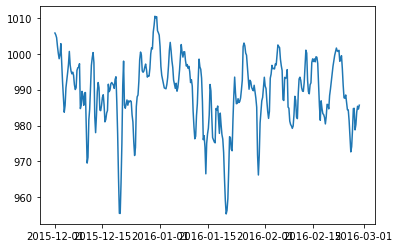

In [29]:
plt.plot(slp_subset['time'],slp_subset)

In [6]:
#Regridding at higher latitudes?

In [ ]:
#Current resolution: 0.5 ° x 0.625 °

In [24]:
new_lat=np.arange(21,54,1)
new_lon=np.arange(-127.5,-53.125,1)

ds_out = xr.Dataset({'lat': (['lat'], new_lat),
                    'lon': (['lon'], new_lon)
                    })

In [25]:
new_lon

array([-127.5, -126.5, -125.5, -124.5, -123.5, -122.5, -121.5, -120.5,
       -119.5, -118.5, -117.5, -116.5, -115.5, -114.5, -113.5, -112.5,
       -111.5, -110.5, -109.5, -108.5, -107.5, -106.5, -105.5, -104.5,
       -103.5, -102.5, -101.5, -100.5,  -99.5,  -98.5,  -97.5,  -96.5,
        -95.5,  -94.5,  -93.5,  -92.5,  -91.5,  -90.5,  -89.5,  -88.5,
        -87.5,  -86.5,  -85.5,  -84.5,  -83.5,  -82.5,  -81.5,  -80.5,
        -79.5,  -78.5,  -77.5,  -76.5,  -75.5,  -74.5,  -73.5,  -72.5,
        -71.5,  -70.5,  -69.5,  -68.5,  -67.5,  -66.5,  -65.5,  -64.5,
        -63.5,  -62.5,  -61.5,  -60.5,  -59.5,  -58.5,  -57.5,  -56.5,
        -55.5,  -54.5,  -53.5])

In [26]:
regridder=xe.Regridder(DS_slp_6hr,ds_out,'bilinear') 
#dr_out=regridder(DS_slp_6hr['SLP']).to_dataset(name='SLP')
#dr_out

Create weight file: bilinear_66x120_33x75.nc


In [27]:
regridder

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_66x120_33x75.nc 
Reuse pre-computed weights? False 
Input grid shape:           (66, 120) 
Output grid shape:          (33, 75) 
Output grid dimension name: ('lat', 'lon') 
Periodic in longitude?      False

In [28]:
dr_out=regridder(DS_slp_6hr['SLP']).to_dataset(name='SLP')
dr_out

<xarray.Dataset>
Dimensions:  (lat: 33, lon: 75, time: 61600)
Coordinates:
  * lon      (lon) float64 -127.5 -126.5 -125.5 -124.5 ... -55.5 -54.5 -53.5
  * lat      (lat) int64 21 22 23 24 25 26 27 28 29 ... 46 47 48 49 50 51 52 53
  * time     (time) datetime64[ns] 1980-01-01 ... 2022-02-28T18:00:00
Data variables:
    SLP      (time, lat, lon) float64 1.018e+05 0.0 0.0 ... 9.952e+04 9.939e+04

Feature Tracking on Unit Sphere: Lagrangian Storm track statistics; Minimizing Cost function?

Filter to only retain spatial scales between T5-T70-use higher wavenumber since SLP is not as noisy as vorticity

tracks
lasting less than 2 days and with displacement of less than
1000 km are removed from the statistics.

In [55]:
#cost function for 3 time steps
#defining an ETC as SLP minimum?
etc=slp_6hr[:,:,:].min(dim='time')
#print(etc)
idx=np.where(etc)
print(idx)
etc_times=slp_time[idx]
print(etc_times)
#idx=xr.where(slp_6hr==etc,1,np.nan)
#print(idx)
#print(np.sum(idx))#7920 tracks
#for i in range()

(array([ 0,  0,  0, ..., 65, 65, 65]), array([  0,   1,   2, ..., 117, 118, 119]))


IndexError: too many indices for array

In [ ]:
#how to cut off wavenumbers??
#distance=slp_6hr[]
#time=
#speed=distance/time
#wavelength=